In [1]:
### Celda para ejecutar en google Colab

from google.colab import drive
import os
drive.mount('/content/gdrive')
root_path = '/content/gdrive/My Drive/Multiples_anotadores'

os.chdir(root_path)
#!pip install -r requirements.txt

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
from scipy.io import loadmat
import numpy as np 
%tensorflow_version 1.x
import tensorflow as tf 
import tensorflow_probability as tfp
import matplotlib.pyplot as plt 
import random
from sklearn.metrics.pairwise import rbf_kernel

from sklearn.base import BaseEstimator, ClassifierMixin

TensorFlow 1.x selected.


Se definen algunas funciones que serán útiles en la implementación

In [3]:
def ook_tf(Y):
    """Transforms Y to 1 of k notation
    n --> data points
    K --> classes
    Y_1ok --> nxK
    """
    
    Y_1ok = tf.one_hot(tf.dtypes.cast(Y, tf.int32),3)

    return Y_1ok

def z_post_tf(pi,p_logreg,K):
    """Calculates the posterior distribution of the latent variable z
    P --> data dimension
    R --> annotators
    N --> data points
    K --> classes
    X --> Pxn
    w_old --> PxK
    p_logreg --> NxR
    pi_old --> Rx1
    post --> RxN
    """
    N = p_logreg.shape[0]
    piM = tf.tile(tf.transpose(pi), [N, 1])
    piM1 = tf.tile((1-tf.transpose(pi)), [N, 1])

    temp1 = piM*p_logreg           
    temp2 = piM1*K
    post = temp1/tf.math.add(temp1,temp2)
    return post

def np2tf(arg):
  arg = tf.convert_to_tensor(arg, dtype=tf.float32)
  return arg

def p_logreg_tf(w,X,Y,R):
    """Calculates the likelihood of the label provided by the rth annotator
    according to a k-class logreg model with parameters w
    p --> data dimension
    n --> data points
    K --> classes
    X --> pxn
    w --> pxK
    p_lr --> NxR
    """
    y_lr = tf.nn.softmax(tf.tensordot(X,w,1))


    t_nk = []

    for r in range(R):
        t_nk.append(ook_tf(Y[:,r])) 


    p_lr = []

    for r in range(R):
        p_lr.append(tf.math.reduce_prod(tf.math.pow((y_lr), t_nk[r]), axis=1))

    return tf.transpose(p_lr)

def p_rand_tf(K):
    return tf.constant(1/K)

Se cargan los datos iris etiquetados por múltiples anotadores (simulados) y a la matriz de datos X se normaliza y se le añade una columna de unos para tener en cuenta el bias.



In [4]:
from scipy import stats
data = loadmat('data/iris1.mat')
#heads = data['MAData'].dtype
X = data['MAData']['X'][0,0]
X = stats.zscore(X)
X = rbf_kernel(X)
X = np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)
t = data['MAData']['t'][0,0]-1
Y = data['MAData']['Y4'][0,0]-1

Se definen algunas variables útiles para el modelo implementado en tensorflow

In [5]:
R = Y.shape[1] 
N = X.shape[0]
K = np.unique(t).size
N_tf = tf.constant(1/N,dtype=tf.float32)
K_tf = tf.constant(1/K,dtype=tf.float32)

# Model inputs
X_tf = tf.placeholder(tf.float32, [X.shape[0], X.shape[1]])
Y_tf = tf.placeholder(tf.float32, [X.shape[0], Y.shape[1]])

# Variables
w = tf.Variable(tf.zeros([X.shape[1], K], tf.float32))
pi = tf.Variable(0.1*tf.ones([Y.shape[1], 1], tf.float32), trainable=False)
Z_p = tf.Variable(0.5*tf.ones(Y.shape, tf.float32), trainable=False)

# Useful variables
Yhat = tf.nn.softmax(tf.tensordot(X_tf,w,1))
p_logreg = p_logreg_tf(w,X_tf,Y_tf,R)


Se plantean las ecuaciones para el algoritmo EM, tomando como función de costo la verosimilitud y como optimizador gradiente descendiente

In [6]:
# Expectation step
auxZ_p = z_post_tf(pi,p_logreg,K_tf)
assingZ = tf.assign(Z_p, auxZ_p)
Z_p_com = 1-Z_p

# Maximization step
auxpi = tf.transpose(tf.math.multiply(tf.reduce_sum(Z_p, axis=0, keepdims=True),N_tf))
assingpi = tf.assign(pi, auxpi)

# Cost function for w (we also could use L; we would obtain the same parameters since pi and Z_p are non-trainable)
C = Z_p*tf.math.log(tf.tile(tf.transpose(pi), [N, 1])*p_logreg)     

#Likelihood 
temp1 = C         
temp2 = Z_p_com*tf.math.log(tf.tile(tf.transpose(1-pi), [N, 1])*K_tf)   
L = tf.math.reduce_sum(tf.math.add(temp1,temp2))

max_iter = 1000

optimizer = tf.train.GradientDescentOptimizer(0.005).minimize(-C)

#optimizer = tf.train.AdamOptimizer(learning_rate=0.01,beta1=0.9,beta2=0.9,epsilon=1e-08).minimize(-temp1)

Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Se inicia la sesión de tesorflow y se entrena el algoritmo de optimización

In [7]:
from IPython.display import clear_output
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    cost_history, accuracy_history = [], [] 
    for it in range(max_iter):
        ### programar paso E
        sess.run(assingZ, feed_dict={X_tf: X, Y_tf: Y})

        ## Paso M
        sess.run([optimizer,assingpi], feed_dict={X_tf: X, Y_tf: Y})

        #Analyze the likelihood 
        Lik = sess.run(L, feed_dict={X_tf: X, Y_tf: Y})
        Yhat1 = sess.run(Yhat, feed_dict={X_tf: X, Y_tf: Y})
        correct_prediction = tf.equal(tf.argmax(Yhat1, 1), (t).T) 
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        accuracy_history.append(accuracy.eval())
        cost_history.append(Lik) 
        #print(Lik)
        if it % 100 == 0: 
          print(it)

    # Let's train the regressor
    Weight = sess.run(w) # Optimized Weight  
    print(sess.run(pi))
    
    #print(sess.run(Z_p))
    
    # Let's check how is performing the regressor
    correct_prediction = tf.equal(tf.argmax(Yhat1, 1), (t).T) 
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print(accuracy.eval())
    #print(Yhat1)
    #print(tf.argmax(Yhat1, 1).eval())

0
100
200
300
400
500
600
700
800
900
[[0.24227361]
 [0.45565742]
 [0.52827215]
 [0.6743785 ]
 [0.08770361]]
0.94


Se grafica el acierto de clasificación y la evolución de la función de costo para cada ciclo

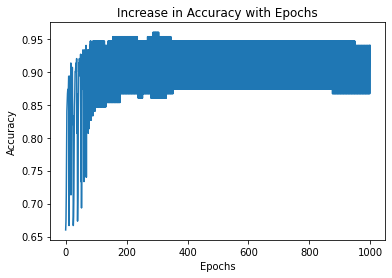

0.94


In [8]:
plt.plot(list(range(max_iter)), accuracy_history) 
plt.xlabel('Epochs') 
plt.ylabel('Accuracy') 
plt.title('Increase in Accuracy with Epochs')


plt.show() 
print(accuracy_history[-1])

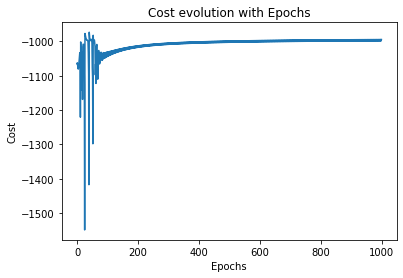

In [9]:
plt.plot(list(range(max_iter)), cost_history  ) 
plt.xlabel('Epochs') 
plt.ylabel('Cost') 
plt.title('Cost evolution with Epochs')
plt.show() 